# Semi-Analytic Solutions for Simple Structures

## Simply-Supported Rectangular Plates

In [1]:
import numpy as np

size = Lx, Ly = (600., 800.)
E = 2890.
nu = 0.2
t = 25.0


In [2]:
from sigmaepsilon.fourier import RectangularPlate
from polymesh import PolyData
from polymesh.grid import grid
from polymesh.trimesh import triangulate
from polymesh.utils.topology.tr import Q4_to_T3

G = E/2/(1+nu)
D = np.array([[1, nu, 0], [nu, 1, 0], [0., 0, (1-nu)/2]]) * \
    t**3 * (E / (1-nu**2)) / 12
S = np.array([[G, 0], [0, G]]) * t * 5 / 6

loads = {
    'LG1': {
        'LC1': {
            'type': 'rectangle',
            'x': [[0, 0], [Lx, Ly]],
            'v': [0, 0, -0.01],
        },
        'LC2': {
            'type': 'rectangle',
            'r': [0.2*Lx, 0.5*Ly, 0.2*Lx, 0.3*Ly],
            'v': [0, 0, -100],
        }
    },
    'LG2': {
        'LC3': {
            'type': 'point',
            'x': [Lx/3, Ly/2],
            'v': [0, 0, -10],
        },
        'LC4': {
            'type': 'point',
            'x': [2*Lx/3, Ly/2],
            'v': [0, 0, 10],
        }
    },
}

shape = nx, ny = (30, 40)
gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0),
    'start': 0,
    'eshape': 'Q4'
}
coords_, topo = grid(**gridparams)
coords = np.zeros((coords_.shape[0], 3))
coords[:, :2] = coords_[:, :]
del coords_
coords, triangles = Q4_to_T3(coords, topo)
triobj = triangulate(points=coords[:, :2], triangles=triangles)[-1]
Mesh = PolyData(coords=coords, topo=triangles)
centers = Mesh.centers()

plate = RectangularPlate(size, (50, 50), D=D, S=S)
results = plate.solve(loads, centers)


TypeError: __init__() got an unexpected keyword argument 'D'

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from dewloosh.mpl.triplot import triplot

plt.style.use('default')


UZ, ROTX, ROTY, CX, CY, CXY, EXZ, EYZ, MX, MY, MXY, QX, QY = list(range(13))
labels = {UZ: 'UZ', ROTX: 'ROTX', ROTY: 'ROTY', CX: 'CX',
          CY: 'CY', CXY: 'CXY', EXZ: 'EXZ', EYZ: 'EYZ',
          MX: 'MX', MY: 'MY', MXY: 'MXY', QX: 'QX', QY: 'QY'}


def plot2d(res2d):
    fig = plt.figure(figsize=(8, 3))  # in inches
    fig.patch.set_facecolor('white')
    cmap = 'jet'
    gs = gridspec.GridSpec(1, 3)
    for i, key in enumerate([UZ, ROTX, ROTY]):
        ax = fig.add_subplot(gs[i])
        triplot(triobj, ax=ax, fig=fig, title=labels[key],
                data=res2d[key, :], cmap=cmap, axis='off')
    fig.tight_layout()

    fig = plt.figure(figsize=(12, 3))  # in inches
    fig.patch.set_facecolor('white')
    cmap = 'seismic'
    gs = gridspec.GridSpec(1, 5)
    for i, key in enumerate([MX, MY, MXY, QX, QY]):
        ax = fig.add_subplot(gs[i])
        triplot(triobj, ax=ax, fig=fig, title=labels[key],
                data=res2d[key, :], cmap=cmap, axis='off')
    fig.tight_layout()


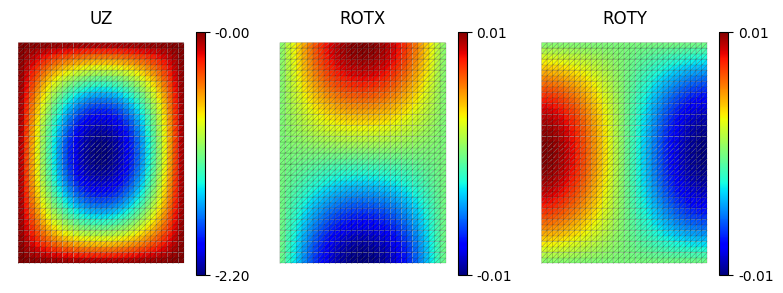

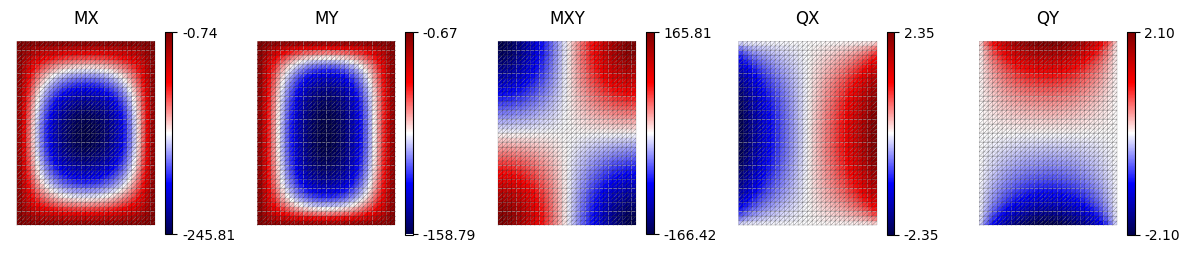

In [ ]:
plot2d(results['LG1', 'LC1'])


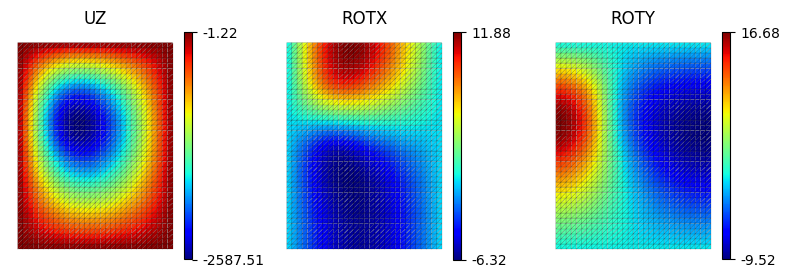

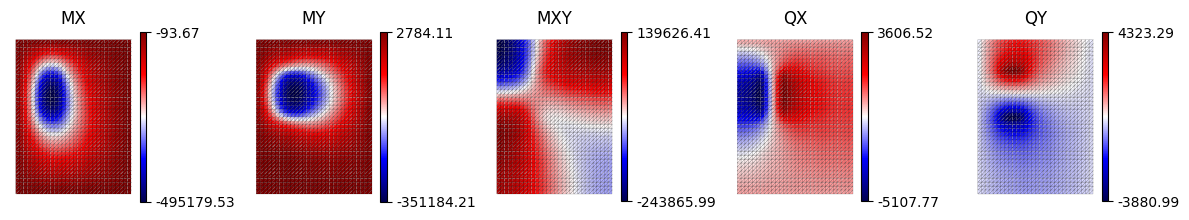

In [ ]:
plot2d(results['LG1', 'LC2'])


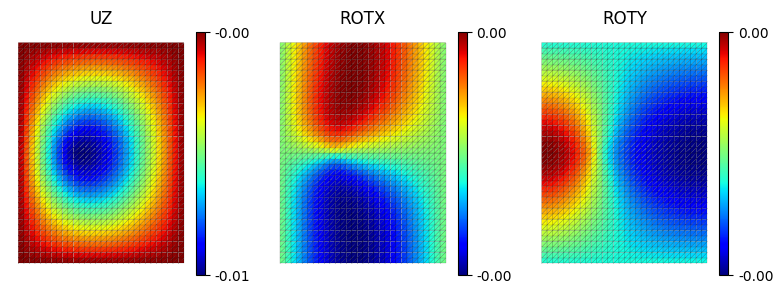

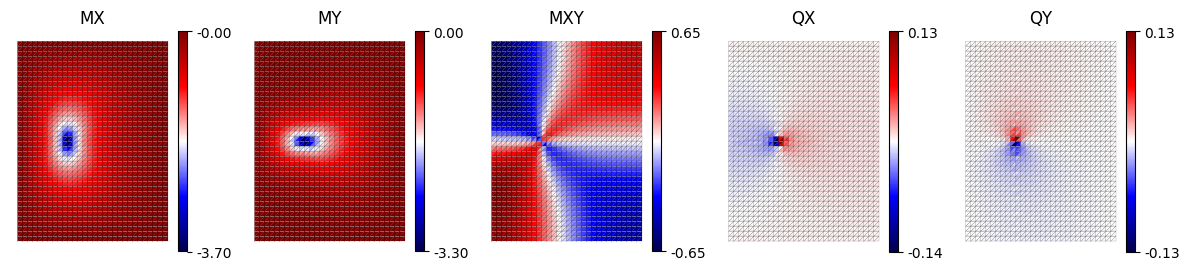

In [ ]:
plot2d(results['LG2', 'LC3'])


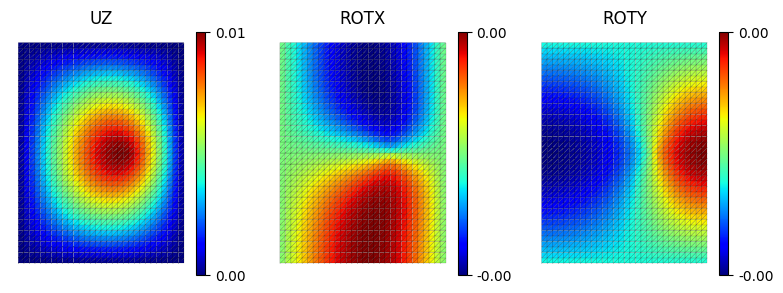

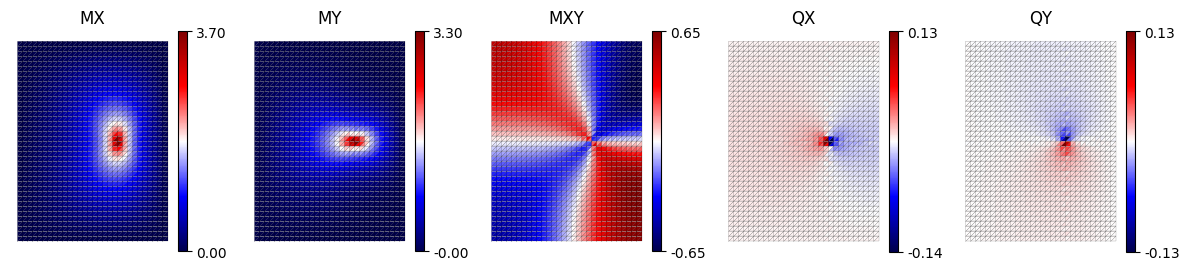

In [ ]:
plot2d(results['LG2', 'LC4'])


## Simply-Supported Beams

In [ ]:
import matplotlib.pyplot as plt

labels = [r'$v$', r'$\theta$', r'$\kappa$',
          r'$\gamma$', r'$M$', r'$V$']
colors = ['b', 'b', 'g', 'g', 'r', 'r']


def plot(x, res):
    fig, axs = plt.subplots(6, 1, figsize=(4, 6), dpi=200, sharex=True)
    for i in range(6):
        axs[i].plot(x, res[:, i], colors[i])
        axs[i].set_xlabel('$x$')
        axs[i].set_ylabel(labels[i])
    plt.subplots_adjust(hspace=0.1)
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
    })
    fig.tight_layout()


In [ ]:
import numpy as np
from sigmaepsilon.fourier import (NavierBeam, LoadGroup,
                                  PointLoad, LineLoad)

L = 1000.0  # geometry
w, h = 20.0, 80.0  # rectangular cross-section
E, nu = 210000.0, 0.25  # material

I = w * h**3 / 12
A = w * h
EI = E * I
G = E / (2 * (1 + nu))
GA = G * A * 5/6

loads = LoadGroup(
    concentrated=LoadGroup(
        LC1=PointLoad(x=L/2, v=[1.0, 0.0]),
        LC5=PointLoad(x=L/2, v=[0.0, 1.0]),
    ),
    distributed=LoadGroup(
        LC2=LineLoad(x=[0, L], v=[1.0, 0.0]),
        LC6=LineLoad(x=[L/2, L], v=[0.0, 1.0]),
    )
)
loads.lock()

x = np.linspace(0, L, 500)


### Timoshenko Beam

In [ ]:
beam = NavierBeam(L, 100, EI=EI, GA=GA)
solution = beam.solve(loads, x)


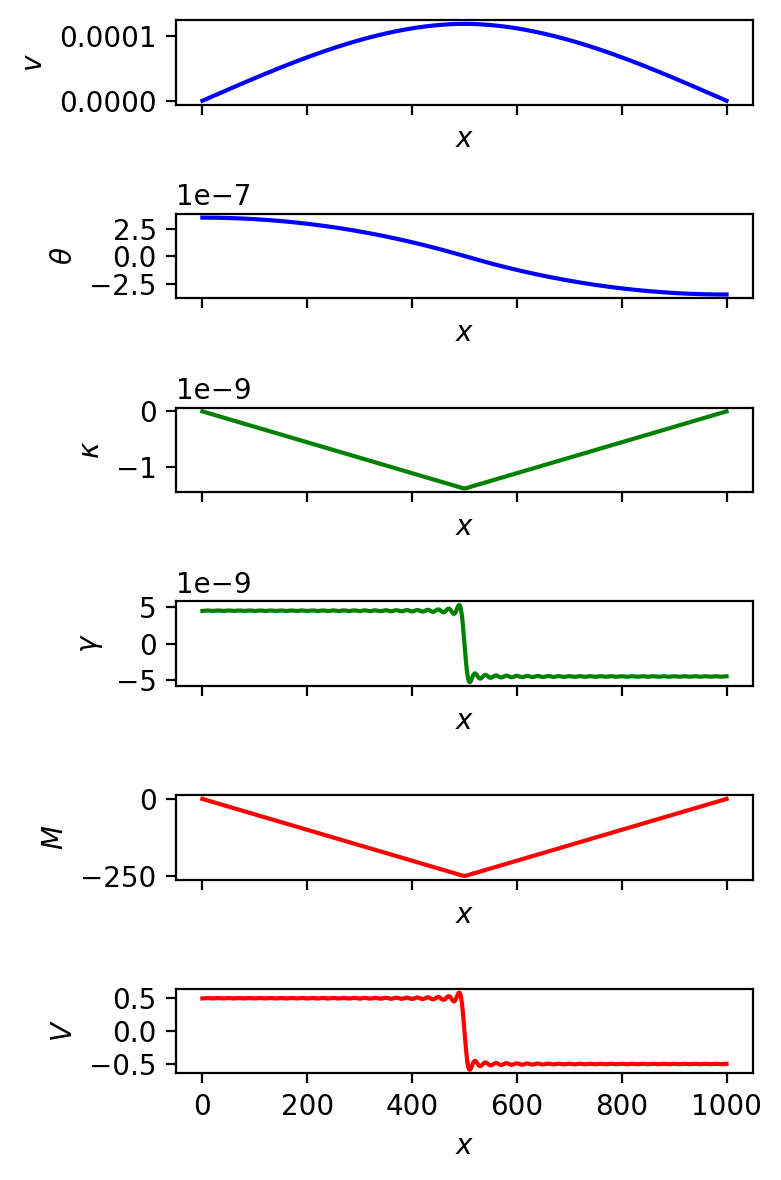

In [ ]:
plot(x, solution['concentrated', 'LC1'])


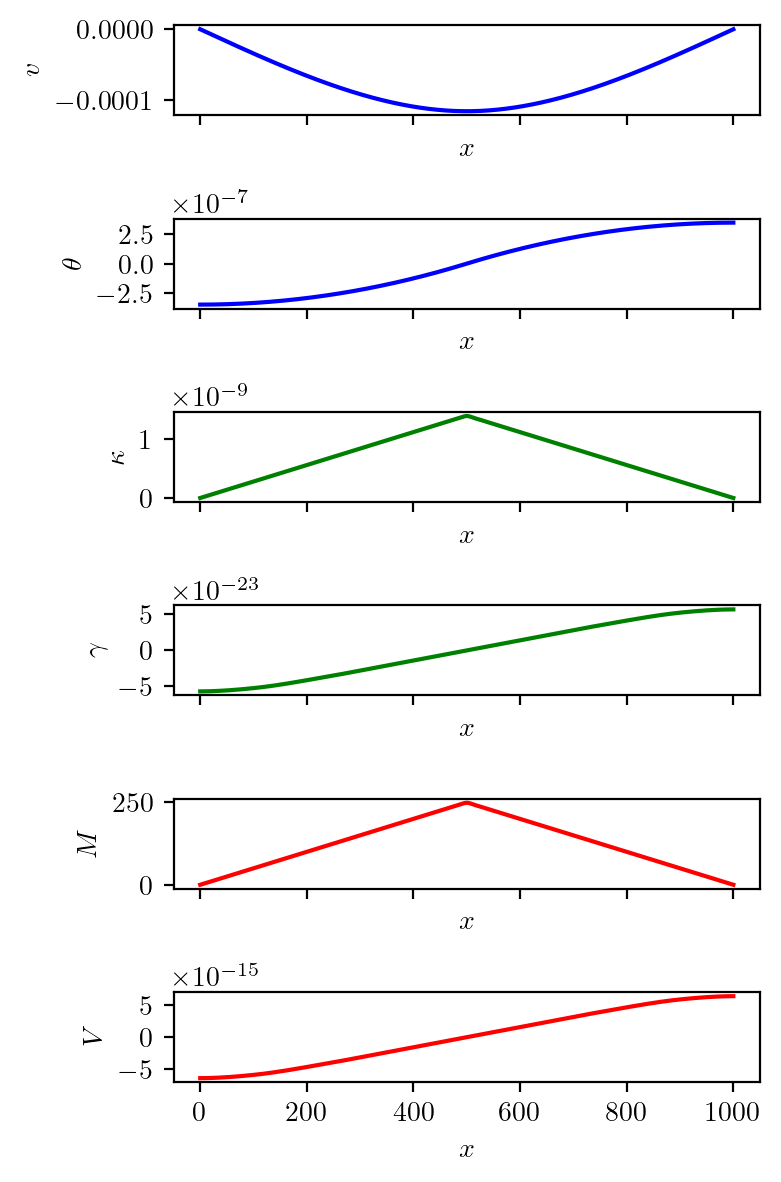

In [ ]:
plot(x, solution['distributed', 'LC6'])


### Euler-Bernoulli Beam

In [ ]:
beam = NavierBeam(L, 100, EI=EI)
solution = beam.solve(loads, x)


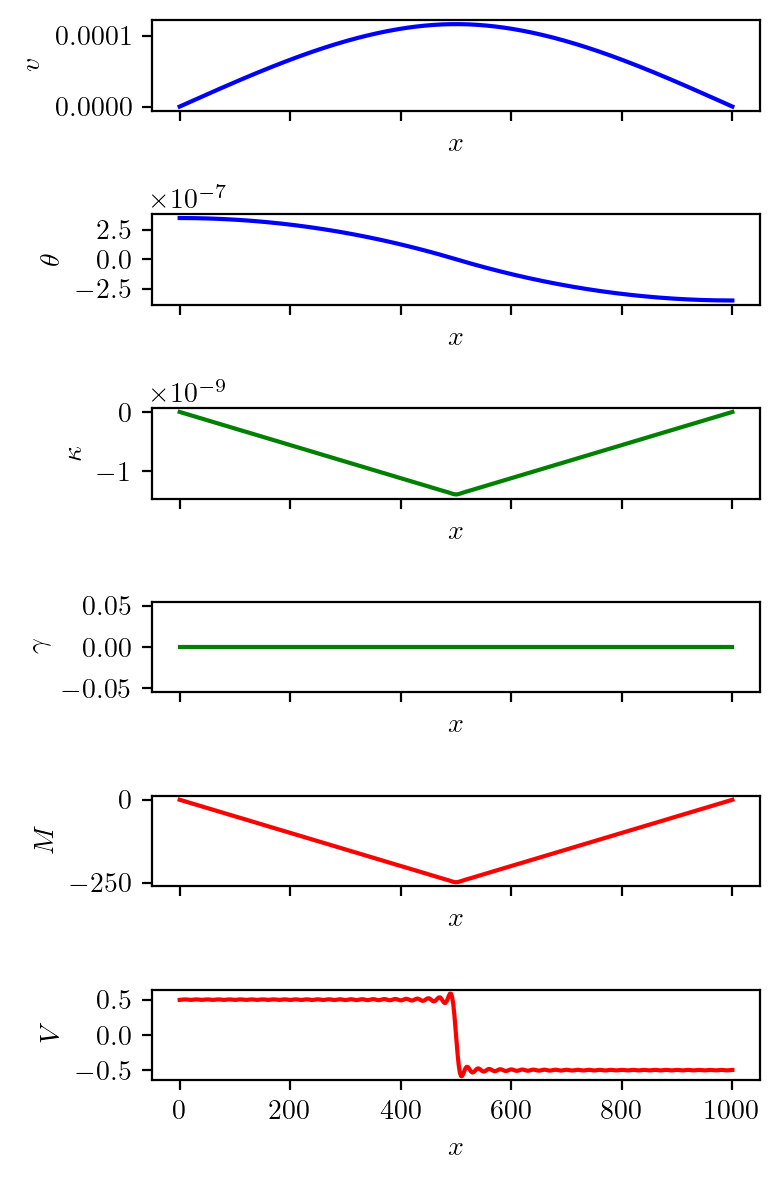

In [ ]:
plot(x, solution['concentrated', 'LC1'])


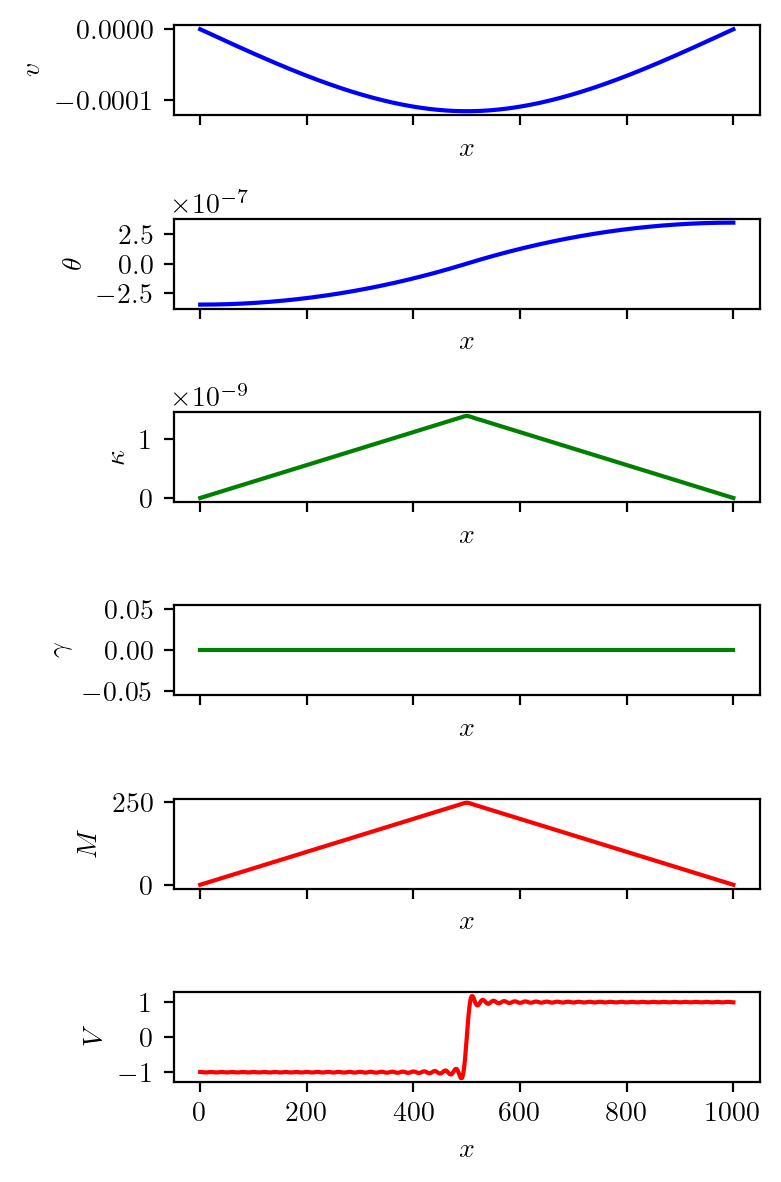

In [ ]:
plot(x, solution['distributed', 'LC6'])
